# Start

In [1]:
### Let's import some libraries ...

import numpy as np
import pandas as pd
import random

import sqlite3
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


random.seed(2021)

Using TensorFlow backend.


# Reading the Data

We have three different sources for data. Below, we read each using the appropriate method into a Pandas data frame.


In [2]:
### Let's read ka_users.csv file as a pandas dataframe
df_ka_users = pd.read_csv("ka_users.csv")

### Let's have a look at the dataframe
display(df_ka_users.head() )
print("shape of the data frame: ", df_ka_users.shape)

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


shape of the data frame:  (2845931, 8)


In [3]:
### Let's read "devices.db" as a pandas dataframe - (stored in a table called 'devices')

conn = sqlite3.connect('ka_devices.db') 
          
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM devices
                               ''', conn)

df_ka_devices = pd.DataFrame(sql_query)
df_ka_devices.drop("index", axis= 1, inplace= True)
display(df_ka_devices.head() )
print("shape of the data frame: ", df_ka_devices.shape)

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


shape of the data frame:  (2845931, 13)


In [4]:
### Let's read "ka_actions.parquet" as a pandas dataframe
df_ka_actions = pq.read_table('ka_actions.parquet').to_pandas()

display(df_ka_actions.head())
print("shape of the data frame: ", df_ka_actions.shape)

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


shape of the data frame:  (2845931, 10)


## Combining the Data


It seems all the data frames have a column in common called "__uid_s__" (which is unique user identifier).

So, let's combine all the data frames into one using "__uid_s__" column. 

In [5]:
### Let's make a dataframe with all the data

df_all_data = pd.merge(pd.merge(df_ka_users, df_ka_actions, on='uid_s'), df_ka_devices, on= "uid_s").copy()
display(df_all_data.head())
print("shape of the data frame: ", df_all_data.shape)

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,logins,game_stats_tutorial_complete,...,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,EN,MY,asia,28800,14,3,0,7.0,1.0,...,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,ES,MX,americas,-18000,14,1,0,2.0,1.0,...,motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,ZH-CN,CN,asia,28800,2,3,0,2.0,1.0,...,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,ZH-CN,CN,asia,28800,8,6,0,3.0,1.0,...,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,EN,IN,asia,19800,19,6,0,4.0,1.0,...,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


shape of the data frame:  (2845931, 29)


Let's look at the columns of our data frame:

In [6]:
### All the columns in our combined dataframe
display(df_all_data.columns.values)

array(['uid_s', 'lang_s', 'geo_s', 'region_s', 'tz_i',
       'local_time_join_hour', 'local_time_join_dow', 'total_spend',
       'logins', 'game_stats_tutorial_complete',
       'game_stats_tutorial_complete_time', 'game_stats_xp',
       'game_stats_xp1', 'game_stats_xp2', 'game_stats_xp3',
       'redeemer_actions', 'scribe_actions', 'platform_s',
       'device_mapped_s', 'device_manufacturer_s', 'device_mem_i',
       'device_gmem_i', 'device_mem_grouping_i', 'device_gmem_grouping_i',
       'device_numcpu_i', 'device_height_i', 'device_gpu_s',
       'device_os_s', 'device_model_s'], dtype=object)

# Data Cleaning

## Removing NaNs

Let's have a closer look at our data frames and see whether we can do any cleaning.

Since the question to be answered is about the users who complete the tutorial, let's have a look at its corresponding feature (as it is a key factor to filter the relevant data).

Let's start with the '__df_ka_actions__' data frame.

In [7]:
### NaN values for 'df_ka_actions'
print("Below shows the number of NaN values for each column in 'df_ka_actions', out of total data of ",df_ka_actions.shape[0] )
display(df_ka_actions.isna().sum() )

Below shows the number of NaN values for each column in 'df_ka_actions', out of total data of  2845931


uid_s                                      0
logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
dtype: int64

So, it seems a good portion of '__game_stats_tutorial_complete__' and '__game_stats_tutorial_complete_time__' are NaNs.

However, if we have a value for '__game_stats_tutorial_complete_time__', the value for '__game_stats_tutorial_complete__' can also be imputed (i.e. if we have a recorded time for '__game_stats_tutorial_complete_time__', we can assign a '1' to the corresponding '__game_stats_tutorial_complete__').

So, let's see whether NaNs in this two columns are on the same rows/users or not.


In [8]:
### Below we first find the rows with NaN for 'game_stats_tutorial_complete_time', 
### and then count NaN for two columns of ['game_stats_tutorial_complete', 'game_stats_tutorial_complete_time']

display ((df_ka_actions[['game_stats_tutorial_complete', 'game_stats_tutorial_complete_time']]\
 [df_ka_actions['game_stats_tutorial_complete_time'].isna()]).isna().sum() )


game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
dtype: int64

It seems unfortunately NaN values in '__game_stats_tutorial_complete__' and '__game_stats_tutorial_complete_time__' overlap. 

Since '__game_stats_tutorial_complete__' is a key parameter to filter for relevant data, users' data with missing '__game_stats_tutorial_complete__' values cannot be very useful.

Beside '__game_stats_tutorial_complete_time__', other parameters could also be studied to impute/predict the value for '__game_stats_tutorial_complete__' (for example by building a classifier from other features etc.). However, for the interest of time, we only focus on users with non-NaN values for now as we still have enough samples.


In [9]:
### Let's again have a look at the number of samples with various 'game_stats_tutorial_complete' 
print("Number of all samples (i.e. rows): ", df_all_data.shape[0])
print("Number of 'game_stats_tutorial_complete' inputs with NaN values:", df_all_data[(df_all_data["game_stats_tutorial_complete"].isna())].shape[0])
print("Number of 'game_stats_tutorial_complete' inputs with value 1:", df_all_data[(df_all_data["game_stats_tutorial_complete"]==1)].shape[0])
print("Number of 'game_stats_tutorial_complete' inputs with value 0:", df_all_data[(df_all_data["game_stats_tutorial_complete"]==0)].shape[0])


Number of all samples (i.e. rows):  2845931
Number of 'game_stats_tutorial_complete' inputs with NaN values: 1088934
Number of 'game_stats_tutorial_complete' inputs with value 1: 1751748
Number of 'game_stats_tutorial_complete' inputs with value 0: 5249


Let's form a new data frame by filtering for "__game_stats_tutorial_complete__" __= 1__ .

In [10]:
### Since the question is about the users who complete the tutorial, let's separate the data for completed toturial

df_tutorial_data = df_all_data[(df_all_data["game_stats_tutorial_complete"]==1)].copy()
print("Number of samples after filtering for 'game_stats_tutorial_complete' = 1 :", df_tutorial_data.shape[0])


Number of samples after filtering for 'game_stats_tutorial_complete' = 1 : 1751748


In [11]:
### Now, let's see if how many other rows still have NaN values in them:
print("Number of samples with NaN values after filtering:", df_tutorial_data.shape[0] - df_tutorial_data.dropna().shape[0])

Number of samples with NaN values after filtering: 144


Above number corresponds to all users/rows that have at least a NaN value after filtering for completed tutorial.

This is a negligible number of samples compared to all the data, so they can be ignored. 

In [12]:
### Let's remove the remaining rows with NaNs 
df_tutorial_data.dropna(inplace= True)


Now, we have a dataframe for samples that completed the tutorial and with all the NaNs are removed.


<br>

## Removing Duplicates

In [13]:
### Let's see if our unique user identifier is indeed unique
print("All the 'uid_s' are unique: ", df_tutorial_data.shape[0]==len(set(df_tutorial_data["uid_s"])))

All the 'uid_s' are unique:  True


In [14]:
### 'uid_s' are unique. However, this could be due to the way data is stored.
### So, let's ignore 'uid_s' and remove duplicates based on other columns.
n_before_dup = df_tutorial_data.shape[0]
df_tutorial_data.drop_duplicates(subset= list(df_tutorial_data.columns.values[1:]), inplace= True)
n_after_dup = df_tutorial_data.shape[0]

print("Number of duplicated rows/samples: ", n_before_dup - n_after_dup)


Number of duplicated rows/samples:  305


Not too many duplicates.

<br>

## Outliers

To check for outliers, let's look at the z-scores.

In [15]:
### First let's find the categorical and numnerical columns
numerical_columns = list(df_tutorial_data.select_dtypes([np.number]).columns.values)
categorical_columns = list(set(df_tutorial_data.columns.values) - set(numerical_columns) )


In [16]:
### 'total_spend' is our target and 'game_stats_tutorial_complete'  is a binary
### So, we remove these from our numerical columns before finding outliers
columns_z_score = list(set(numerical_columns) - set(['total_spend','game_stats_tutorial_complete' ] ) )
df_z_score = df_tutorial_data.loc[: , columns_z_score].copy()

z_scores = stats.zscore(df_z_score)
abs_z_scores = np.abs(z_scores)
entries_no_outliers = (abs_z_scores < 3).all(axis=1)
new_df_z_score = df_z_score[entries_no_outliers].copy()

index_no_outliers = list(new_df_z_score.index.values)

### The dataframe below is without detected outliers
df_tutorial_no_out = df_tutorial_data.loc[index_no_outliers, :].copy()


So, should we use the data frame without outliers?

Let's have a closer look at our data ...

In [17]:
print("ratio of users with spending to total: ",np.round( (sum(df_tutorial_data["total_spend"]>0)/df_tutorial_data.shape[0] ), 4 ))

ratio of users with spending to total:  0.0175


This is a very small portion of our data (less than 2%).

In other words, our data is highly __imbalanced__!

Now, let's have a look at our outliers again:

In [18]:
n_total_samples = df_tutorial_data.shape[0]
n_total_outliers = df_tutorial_no_out.shape[0]

n_users_spending = sum(df_tutorial_data["total_spend"]>0)
n_users_spending_outliers = sum(df_tutorial_data["total_spend"]>0) - sum(df_tutorial_no_out["total_spend"]>0) 

print("ratio of outlier to total: ", np.round( (n_total_samples-n_total_outliers)/n_total_samples, 3) )
print("ratio of 'users with spending in the outliers' to 'all users with spending': ", 
np.round(n_users_spending_outliers/n_users_spending , 3 ) )
    

ratio of outlier to total:  0.092
ratio of 'users with spending in the outliers' to 'all users with spending':  0.355


So, while we are detecting about 9% of all data as outliers, around 36% of our very valuable data of 'users with spending' are included in these outliers.

This is suggesting that these outliers are meaningful for our particular question, and can probably be useful. 

So, let's decide to keep the detected outliers for now! However, we need to come back to this for further investigation.


<br>

These were some steps of data cleaning. Much more needs to be done. But, let's move forward for now.

<br>


# Feature Engineering

## Dependent Variable

First, let's consider our dependent variable.

Since the question is only whether a user will spend money or not (rather than how much one may spend), we define a new column for our dependent variable as a binary:

0 for no spending

1 for some spending

This way, we are changing the question to a binary classification problem.

In [19]:
### Since the question is only whether a user will spend money or not (rather than how much one may spend), 
### we can define our dependent variable as 0 and 1 (rather than total_spend)

df_tutorial_data["spending_status"] = np.where(df_tutorial_data["total_spend"]>0, 1, 0)


We will consider "__spending_status__" as our future dependent variable or __y__.

## Independent Variables

Now, let's make separate dataframe for our independent variables or __X__.

In [20]:
### Now, let's form a separate dataframe for our features:
### Let's make a copy of the df_tutorial_data dataframe
df_X = df_tutorial_data.copy()

### Let's remove the total_spend and "spending_status"
df_X.drop(["total_spend", "spending_status"], axis= 1, inplace= True)

### Also, the "uis_s" should not have an effect on our model. So, let's remove it from our features:
df_X.drop(["uid_s"], axis= 1, inplace= True)

### We also do not need "game_stats_tutorial_complete" column as it is 1 for all inputs
### Remeber 'df_tutorial_data' has already filtered for users who completed the tutorial.
df_X.drop(["game_stats_tutorial_complete"], axis= 1, inplace= True)


### Drop Highly Correlated Features

Let's see if there is any strong correlation between our independent features.

We can look at the pairwise correlation of between all features. This will be for all columns that are numerical at this point.

In [21]:
### Let's have a look at the correlation between features that are not categorical:
df_corr = df_X.corr()
display(df_corr)


,tz_i,local_time_join_hour,local_time_join_dow,logins,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
tz_i,1.000000,-0.038140,0.052422,-0.009981,-0.031488,-0.011003,0.013460,-0.009323,-0.012320,0.001642,0.023013,0.128798,0.260943,0.128913,0.260943,0.287946,0.111431
local_time_join_hour,-0.038140,1.000000,0.053052,-0.038082,-0.064428,-0.024947,0.010289,-0.003906,-0.008600,-0.029171,-0.046410,-0.000459,-0.001168,-0.000442,-0.001168,0.000239,0.016145
local_time_join_dow,0.052422,0.053052,1.000000,0.003974,-0.002185,-0.000025,0.007588,-0.000526,-0.002329,0.006924,0.012386,0.007518,0.016320,0.007511,0.016320,0.025038,0.011151
logins,-0.009981,-0.038082,0.003974,1.000000,0.162000,0.193170,0.043909,0.134656,0.146396,0.234424,0.518719,-0.020889,-0.042930,-0.020902,-0.042930,-0.060526,-0.025786
game_stats_tutorial_complete_time,-0.031488,-0.064428,-0.002185,0.162000,1.000000,-0.048662,-0.222335,-0.042329,-0.011312,-0.066293,0.017189,-0.020792,-0.040900,-0.020794,-0.040900,-0.018761,-0.050059
game_stats_xp,-0.011003,-0.024947,-0.000025,0.193170,-0.048662,1.000000,0.553211,0.703907,0.718229,0.907752,0.705679,0.030275,0.060672,0.030320,0.060672,0.004718,0.065288
game_stats_xp1,0.013460,0.010289,0.007588,0.043909,-0.222335,0.553211,1.000000,0.479203,0.275759,0.666813,0.589982,0.056256,0.111971,0.056304,0.111971,0.035495,0.127104
game_stats_xp2,-0.009323,-0.003906,-0.000526,0.134656,-0.042329,0.703907,0.479203,1.000000,0.562619,0.691452,0.557547,0.022266,0.044261,0.022295,0.044261,0.002380,0.047563
game_stats_xp3,-0.012320,-0.008600,-0.002329,0.146396,-0.011312,0.718229,0.275759,0.562619,1.000000,0.640655,0.484068,0.014712,0.029575,0.014741,0.029575,-0.003702,0.030960
redeemer_actions,0.001642,-0.029171,0.006924,0.234424,-0.066293,0.907752,0.666813,0.691452,0.640655,1.000000,0.867399,0.043887,0.087570,0.043951,0.087570,0.021334,0.093597


In [22]:
### Let's see if there are columns that have very high correlation with another column
### We look for values more than 1, which means that column is correlating with at least another column than itself.

df_corr = df_X.corr()

### This is the threshold for considering two parameters correlated
corr_thresh = 0.95

print("Below shows the number of features correlated with each feature. This includes the the feature itself.")
display((abs(df_corr )>corr_thresh).sum())


Below shows the number of features correlated with each feature. This includes the the feature itself.


tz_i                                 1
local_time_join_hour                 1
local_time_join_dow                  1
logins                               1
game_stats_tutorial_complete_time    1
game_stats_xp                        1
game_stats_xp1                       1
game_stats_xp2                       1
game_stats_xp3                       1
redeemer_actions                     1
scribe_actions                       1
device_mem_i                         2
device_gmem_i                        2
device_mem_grouping_i                2
device_gmem_grouping_i               2
device_numcpu_i                      1
device_height_i                      1
dtype: int64

In [23]:
### Let's look at parameters that correlate with parameters other than themselves

corr_display = list((abs(df_corr )>corr_thresh).sum()[(abs(df_corr )>corr_thresh).sum()>1].index.values)

display(df_corr.loc[corr_display , corr_display ])

,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i
device_mem_i,1.000000,0.443553,0.999985,0.443553
device_gmem_i,0.443553,1.000000,0.443501,1.000000
device_mem_grouping_i,0.999985,0.443501,1.000000,0.443501
device_gmem_grouping_i,0.443553,1.000000,0.443501,1.000000


In [24]:
print("It seems 'device_gmem_i' and 'device_gmem_grouping_i' are highly correlated. So, we remove one of them.")
print("It seems 'device_mem_i' and 'device_mem_grouping_i'are aslo highly correlated. So, we remove one of them.")

### Let's remove above
df_X.drop(['device_gmem_grouping_i', 'device_mem_grouping_i'], axis= 1, inplace= True)

It seems 'device_gmem_i' and 'device_gmem_grouping_i' are highly correlated. So, we remove one of them.
It seems 'device_mem_i' and 'device_mem_grouping_i'are aslo highly correlated. So, we remove one of them.


### Dummies for Categorical Features

In [25]:
### Let's have look at number of unique values for categorical variables:

df_X_cat = df_tutorial_data.loc[:, categorical_columns ].copy()

print("Below shows the number of unique values for each categotrical variable:")
display(pd.Series([len(set(df_X_cat.iloc[:, i ])) 
               for i in range(df_X_cat.shape[1])], 
              index=df_X_cat.columns).sort_values() )

Below shows the number of unique values for each categotrical variable:


platform_s                   2
region_s                     5
lang_s                      17
geo_s                      218
device_gpu_s               426
device_manufacturer_s     2047
device_mapped_s          14098
device_model_s           14194
device_os_s              56492
dtype: int64

In [26]:
print('For now, we only include the categorical features with smaller number of unique values.')
print('This is to prevent generating too many features if we decided to convert these features to dummies.')
print('Please note that this should be revisited later on if needed.')

### Let's remove some of the categorical features for now:
categorical_columns_to_drop = ['geo_s', 'device_gpu_s', 'device_manufacturer_s', 'device_mapped_s', 'device_model_s', 'device_os_s']
df_X.drop(categorical_columns_to_drop, axis= 1, inplace= True)


For now, we only include the categorical features with smaller number of unique values.
This is to prevent generating too many features if we decided to convert these features to dummies.
Please note that this should be revisited later on if needed.


Below, we create dummies for the remaining categorical features:

In [27]:
### Let's create the dummies
list_var_dummies = list(set(df_X_cat.columns)- set(categorical_columns_to_drop) )
print("Categorical columns for dummies: ", list_var_dummies)
var_dummies = pd.get_dummies(df_X[list_var_dummies])
### Let's add new columns to our df_X
df_X[var_dummies.columns.values] = var_dummies

### Let's drop the original columns
df_X.drop(list_var_dummies, axis= 1, inplace= True)


Categorical columns for dummies:  ['region_s', 'lang_s', 'platform_s']


In [28]:
df_X.shape

(1751299, 39)

In [29]:
### Again, let's see if there are columns that have very high correlation with another column
### We look for values more than 1, which means that column is correlating with at least another column than itself.

df_corr = df_X.corr()
corr_thresh = 0.95

print("Below shows the number of features correlated with each feature. This includes the the feature itself.")
display((abs(df_corr )>corr_thresh).sum().sort_values(ascending=False).head(10))

print("It seems 'platform_s_android' and 'platform_s_iphone' are correlating. Let's have a closer look:")


Below shows the number of features correlated with each feature. This includes the the feature itself.


platform_s_iphone       2
platform_s_android      2
local_time_join_hour    1
local_time_join_dow     1
region_s_asia           1
region_s_americas       1
region_s_africa         1
device_height_i         1
device_numcpu_i         1
device_gmem_i           1
dtype: int64

It seems 'platform_s_android' and 'platform_s_iphone' are correlating. Let's have a closer look:


In [30]:
display(df_corr.loc[['platform_s_android',  'platform_s_iphone'], ['platform_s_android',  'platform_s_iphone']])

print("Since we only had 2 categories for original feature of 'platform_s', they are anti-correlating.")
print("This makes sense, as knowing about one of them, defines the other.")      

print("So, let's remove one of them.")


,platform_s_android,platform_s_iphone
platform_s_android,1.0,-1.0
platform_s_iphone,-1.0,1.0


Since we only had 2 categories for original feature of 'platform_s', they are anti-correlating.
This makes sense, as knowing about one of them, defines the other.
So, let's remove one of them.


In [31]:
### Removing 'platform_s_android'
df_X.drop(['platform_s_android'], axis= 1, inplace= True)



For now, above dataframe has our independent variables. So, let's move to the next step.

# Model Training and Tuning

## Quick Test of Multiple Models

Here we test a few models to see how they generally perform.

We do the following steps:

__Split data for training, validation and test__: We first split the data to 'remainder' and 'test'. We will set the 'test' aside for the very final test of our model.

We then split the 'remainder' to 'train' and 'validation'. The 'train' will be used to train our model, and the 'validation' will be used for hyperparameter optimization etc. This way we make sure that we keep the 'test' set aside for the very final check of the model.

The above is possible because we do have enough data.

__Over/Under Sampling of training data__: Since our data is highly imbalanced, we need to re-sample our data for training purposes. We over-sample the data related to users with payment, and under-sample the data for users that didn't make any payment.

__Evaluation__: We are interested in users that are likely to spend money in the game. These are the minority group (also considered as the positive class) in our imbalanced data. So, we want to maximize the recall (True Positive Rate) and precision (Positive Predictive Value) in predicting this minority/positive class. Thus, we use the F1 score to evaluate the model's performance for this imbalanced data set.


In [32]:
### For the sake of clarity in outputs display
import warnings
warnings.filterwarnings("ignore")


----------------------------- 

Current model is:  Logit 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.824
maximum F1 score for validation data is:  0.206 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[403165,   9781],
       [  5393,   1973]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[335818,   8304],
       [  4525,   1613]])

Recall score for test set is:  0.263
Precision score for test set is:  0.163
F1 score for test set is:  0.201


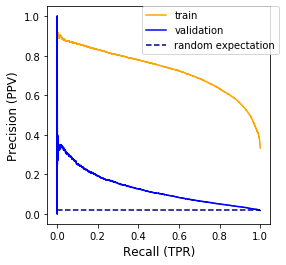

----------------------------- 

Current model is:  SVM 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.31
maximum F1 score for validation data is:  0.034 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[    40, 412906],
       [     0,   7366]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[    32, 344090],
       [     0,   6138]])

Recall score for test set is:  1.0
Precision score for test set is:  0.018
F1 score for test set is:  0.034


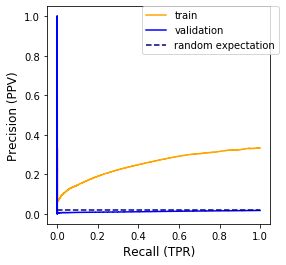

----------------------------- 

Current model is:  RF 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.6
maximum F1 score for validation data is:  0.185 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[403922,   9024],
       [  5699,   1667]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[336531,   7591],
       [  4780,   1358]])

Recall score for test set is:  0.221
Precision score for test set is:  0.152
F1 score for test set is:  0.18


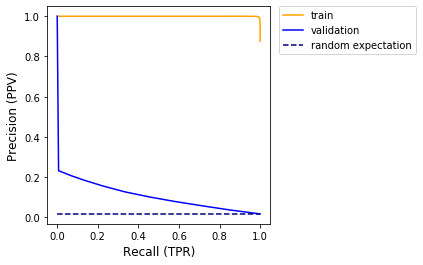

----------------------------- 

Current model is:  AB 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.502
maximum F1 score for validation data is:  0.162 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[398052,  14894],
       [  5405,   1961]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[331597,  12525],
       [  4509,   1629]])

Recall score for test set is:  0.265
Precision score for test set is:  0.115
F1 score for test set is:  0.161


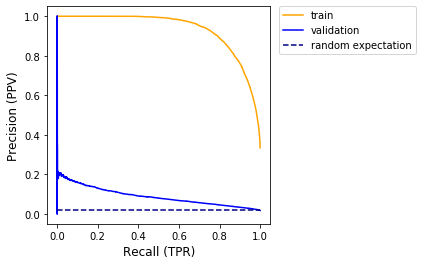

----------------------------- 

Current model is:  GB 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.466
maximum F1 score for validation data is:  0.199 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[400805,  12141],
       [  5209,   2157]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[333986,  10136],
       [  4417,   1721]])

Recall score for test set is:  0.28
Precision score for test set is:  0.145
F1 score for test set is:  0.191


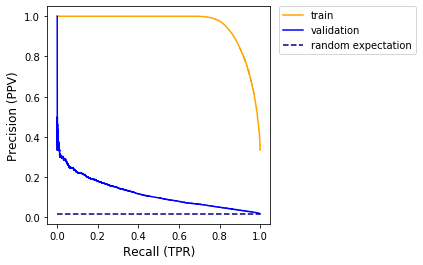

----------------------------- 

Current model is:  XGB 

Let's find which probability threshold maximizes F1 score ...
the corresponding threshold for maximum F1 score is:  0.499
maximum F1 score for validation data is:  0.195 

Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:


array([[402454,  10492],
       [  5438,   1928]])


Now, let's evaluate the model on the test set ...
Let's look at the confusion matrix for test data:


array([[335413,   8709],
       [  4600,   1538]])

Recall score for test set is:  0.251
Precision score for test set is:  0.15
F1 score for test set is:  0.188


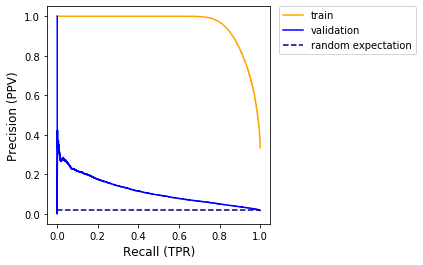

In [33]:
### First we saparate our data to "remainder" and "test"
### The "test" will not be used until very end.
### The "remainder" will be broken to "train" and "validation" for optimizing the model etc.

### Taking a chunck for our 20% test set
y = df_tutorial_data["spending_status"]
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(df_X, y, stratify= y, test_size = 0.2,
                     random_state=1)

### Splitting the resampled data in two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder,stratify= y_remainder, test_size = 0.3,
                     random_state=1)

### The data is heavily imbalanced; 
### i.e. number of users who spend money are much smaller than total
### Let's synthetically increase the data related to paid users
### This brings the ratio of positive (smaller) to negative (larger) group to 1:10.
oversample = SMOTE(sampling_strategy=0.1, random_state= 1)
X_r_os, y_r_os = oversample.fit_resample(X_train, y_train)
### SMOTE has been suggested to work better if the other class is also under sampled
### So, let's under sample the users data with no spending
### This brings the ratio of positive (smaller) to negative (larger) group to 1:2.
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state= 1)
X_r_us, y_r_us = undersample.fit_resample(X_r_os, y_r_os)

### Let's redefine our train data after re-sampling
X_train = X_r_us
y_train = y_r_us

### Let's scale the data as some of the models below may work better this way
### However, for some models like Random Forest it does not matter.
scaler = StandardScaler()
scaler.fit(X_train)
X_train_SS = scaler.transform(X_train)
X_validation_SS = scaler.transform(X_validation)
X_test_SS = scaler.transform(X_test)


### Here we define some models
my_logit = LogisticRegression(solver='lbfgs', random_state= 1)
my_SVM = SVC(probability=True, kernel='poly', max_iter=100, random_state= 1)
my_RF = RandomForestClassifier(random_state= 1)
my_AB = AdaBoostClassifier(random_state= 1)
my_GB = GradientBoostingClassifier(random_state= 1)
my_XGB = XGBClassifier(random_state= 1)


my_models = [("Logit", my_logit), 
             ("SVM",my_SVM),
             ("RF",my_RF), 
             ("AB",my_AB), 
             ("GB",my_GB), 
             ("XGB",my_XGB)
            ]


for model_tuple in my_models:
    model_name = model_tuple[0]
    model = model_tuple[1]
    print("-----------------------------", "\n")
    print("Current model is: ", model_name, "\n")
    model.fit(X_train_SS, y_train)
    
    ### We want to look at precision-recall curves, so let's predict for probabilities
    y_proba_validation = model.predict_proba(X_validation_SS)[:, 1]
    y_proba_train = model.predict_proba(X_train_SS)[:, 1]

    ### Due to the nature of our question, we are more interested in Precision-Recall curves
    precision_train, recall_train, thresh_train = precision_recall_curve(y_train, 
                                          y_proba_train)

    precision_validation, recall_validation, thresh_validation = precision_recall_curve(y_validation, 
                                        y_proba_validation)
    
    print("Let's find which probability threshold maximizes F1 score ...")

    ### Let's find the corresponding F1 scores, and the probability threshold where it maximizes  
    ### We then report this value as the best F1 score for our validation, and the corresponding confusion matrix
    ### We also use the corresponding threshold to predict for the test set
    f1_validation_array = (2*precision_validation*recall_validation/(precision_validation+recall_validation))[:-1]
    ix_max = np.nanargmax(f1_validation_array)
    max_f1_validation = f1_validation_array[ix_max]
    max_f1_validation_threshold = thresh_validation[ix_max]
    
    ### Let's find the predictions for validation dataset for "max_f1_validation_threshold"
    y_validation_pred = np.where(y_proba_validation>=max_f1_validation_threshold, 1, 0)


    print("the corresponding threshold for maximum F1 score is: ", np.round(max_f1_validation_threshold , 3) )
    print("maximum F1 score for validation data is: ", np.round(max_f1_validation, 3) , "\n")

    
    ### Let's look at the confusion matrix
    print("Let's look at the corresponding confusion matrix for maximum F1 score case - validation data:")
    display(confusion_matrix(y_validation, y_validation_pred) )


    print("")
    print("Now, let's evaluate the model on the test set ...")

    ### Let's predict for test dataset
    y_proba_test = model.predict_proba(X_test_SS)[:, 1]
    y_test_pred = np.where(y_proba_test>=max_f1_validation_threshold, 1, 0)

    ### Let's look at the confusion matrix
    print("Let's look at the confusion matrix for test data:")
    display(confusion_matrix(y_test, y_test_pred) )

    print("Recall score for test set is: ", np.round(recall_score(y_test, y_test_pred), 3) )
    print("Precision score for test set is: ", np.round(precision_score(y_test, y_test_pred), 3) )
    print("F1 score for test set is: ", np.round(f1_score(y_test, y_test_pred), 3) )

    
    
    plt.figure(figsize= (4,4))
    plt.plot(recall_train, precision_train,  c="orange", label="train" )
    plt.plot(recall_validation, precision_validation,  c="blue", label="validation" )
    plt.plot(np.arange(0, 1.01, 0.01), np.ones(101)*sum(y)/len(y), color='navy', linestyle='--', label="random expectation")
    plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)
    plt.xlabel("Recall (TPR)", fontsize= 12)
    plt.ylabel("Precision (PPV)", fontsize= 12)
    plt.show();
    

Please note that we used above models out of the box to have a rough idea of how they are doing. This is not their best performance as there are many model's parameters to be tuned. It is just a demonstration of the approach.

<br>

## Hyperparameter Optimization

Most of the above models performed similarly. Let's choose one of them to tune for some hyperparameters to see whether we can improve its performance.
Here, we investigate the Random Forest model further.

We use F1 score to evaluate models. To make sure splitting our data for training is not affecting our evaluation, we do a cross validation and find the average of F1 scores.



Here, we study the effect of 'max_depth' hyperparameter in Random Forest model.


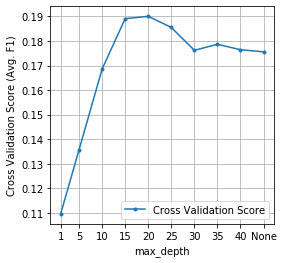

In [34]:
### First we saparate our data to "remainder" and "test"
### We do not split the 'remainder' to 'train' and 'validation' this time
### because we want to use the cross validation method directly
### Taking a chunck for our 20% test set:
y = df_tutorial_data["spending_status"]
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(df_X, y, stratify= y, test_size = 0.2,
                     random_state=1)

### Store the scores
cross_validation_scores = []

### Define the range of 'max_depth' parameter here
d_range = [1, 5, 10, 15, 20, 25, 30, 35, 40, None]


#Do some cross validation
for d in d_range:
    print("current 'max_depth' value: ", d, end="\r")

    ### First let's define our model 
    my_RF = RandomForestClassifier(max_depth= d, random_state= 1)

    ### The data is heavily imbalanced; 
    ### i.e. number of users who spend money are much smaller than total
    ### Let's synthetically increase the data related to paid users
    ### This brings the ratio of positive (smaller) to negative (larger) group to 1:10.
    over_sampling = SMOTE(sampling_strategy=0.1, random_state= 1)
    ### SMOTE has been suggested to work better if the other class is also under sampled
    ### So, let's under sample the users data with no spending
    ### This brings the ratio of positive (smaller) to negative (larger) group to 1:2.
    under_sampling = RandomUnderSampler(sampling_strategy=0.5, random_state= 1)
    
    ### Let's use a pipeline for our calculations
    ### Here is the steps for our pipeline
    steps = [('over', over_sampling), ('under', under_sampling), ('model', my_RF)]
    ### Let's define the pipeline
    pipeline = Pipeline(steps=steps)
    ### evaluate pipeline
    ### Please note that number of repeats is chosen low for running time purposes
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    f1_scores = cross_val_score(pipeline, X_remainder, y_remainder, scoring='f1', cv=cv, n_jobs=-1)
    
    ### the cross validation score (mean of scores from all folds)
    cv_score = np.mean(f1_scores)
        
    cross_validation_scores.append(cv_score)
    
plt.figure(figsize= (4,4))
x_plot = np.append(d_range[:-1],(2*d_range[-2] - d_range[-3] ) ) # to create 45 (rather than None) after 40
plt.plot(x_plot, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel('max_depth')
plt.ylabel('Cross Validation Score (Avg. F1)')
plt.xticks(x_plot ,[str(x) for x in d_range])
plt.grid()
plt.show();


So, the above plot suggests that in a 'max_depth' of around 20 works the best. This is probably because using very high depths make our model to over-fit to the training data. 

One can now do a higher resolution search around the value of 20, to find an even more optimized value.

<br>

Also, if more than one hyperparameter is needed to be optimized at the same time, one can perform a grid search for the corresponding hyperparameters.

One should also note that we also have some parameters outside of our model that can be optimized. For example for our case, because the dataset is heavily imbalanced, we tried to re-sample (over and under sample) our data before training.

So far we only used 1:10 ratio for oversampling, and then 1:2 ratio for under sampling.

Let's investigate one of these parameters further and see whether it changes our model's performance.

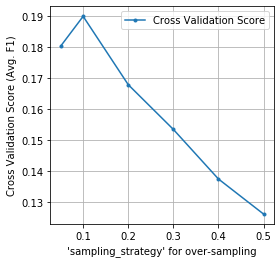

In [35]:
### First we saparate our data to "remainder" and "test"
### We do not split the 'remainder' to 'train' and 'validation' this time
### because we want to use the cross validation method directly
### Taking a chunck for our 20% test set
y = df_tutorial_data["spending_status"]
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(df_X, y, stratify= y, test_size = 0.2,
                     random_state=1)

### Store the scores
cross_validation_scores = []

### Define the range of 'sampling_strategy' parameter below
s_range = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


#Do some cross validation
for s in s_range:
    print("current 'sampling_strategy' value for SMOTE: ", s, end="\r")

    ### First let's define our model 
    my_RF = RandomForestClassifier(max_depth= 20, random_state= 1)

    ### The data is heavily imbalanced; 
    ### i.e. number of users who spend money are much smaller than total
    ### Let's synthetically increase the data related to paid users
    ### This brings the ratio of positive (smaller) to negative (larger) group to 1:10.
    over_sampling = SMOTE(sampling_strategy=s, random_state= 1)
    ### SMOTE has been suggested to work better if the other class is also under sampled
    ### So, let's under sample the users data with no spending
    ### This brings the ratio of positive (smaller) to negative (larger) group to 1:2.
    under_sampling = RandomUnderSampler(sampling_strategy=0.5, random_state= 1)
    
    ### Let's use a pipeline for our calculations
    ### Here is the steps for our pipeline
    steps = [('over', over_sampling), ('under', under_sampling), ('model', my_RF)]
    ### Let's define the pipeline
    pipeline = Pipeline(steps=steps)
    ### evaluate pipeline
    ### Please note that number of repeats is chosen low for running time purposes
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
    f1_scores = cross_val_score(pipeline, X_remainder, y_remainder, scoring='f1', cv=cv, n_jobs=-1)
    
    ### the cross validation score (mean of scores from all folds)
    cv_score = np.mean(f1_scores)
        
    cross_validation_scores.append(cv_score)
    
plt.figure(figsize= (4,4))
plt.plot(s_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xlabel("'sampling_strategy' for over-sampling")
plt.ylabel('Cross Validation Score (Avg. F1)')
plt.grid()
plt.show();

It seems the 'sampling_strategy=0.1' worked the best between the tested values.

## Final Model Evaluation on Test Set


Although there is still a lot that can be done, let's assume we have finalized our model.

Let's do one final run, and evaluate the final model on 'test' data using optimized hyperparameters.


In [36]:
### First we saparate our data to "remainder" and "test"
### The "test" will not be used until very end.
### The "remainder" will be broken to "train" and "validation" for fitting the model etc.
y = df_tutorial_data["spending_status"]

### Taking a chunck for our 20% test set
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(df_X, y, stratify= y, test_size = 0.2,
                     random_state=1)

### Splitting the resampled data in two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder,stratify= y_remainder, test_size = 0.3,
                     random_state=1)

### The data is heavily imbalanced; 
### i.e. number of users who spend money are much smaller than total
### Let's synthetically increase the data related to paid users
### This brings the ratio of positive (smaller) to negative (larger) group to 1:10.
### ***Please note that 'sampling_strategy' has been optimized above!***
oversample = SMOTE(sampling_strategy=0.1, random_state= 1)
X_r_os, y_r_os = oversample.fit_resample(X_train, y_train)
### SMOTE has been suggested to work better if the other class is also under sampled
### So, let's under sample the users data with no spending
### This brings the ratio of positive (smaller) to negative (larger) group to 1:2.
undersample = RandomUnderSampler(sampling_strategy=0.5, random_state= 1)
X_r_us, y_r_us = undersample.fit_resample(X_r_os, y_r_os)

### Let's redefine our train data after re-sampling
X_train = X_r_us
y_train = y_r_us

### Please note that we do not need to scale the data for Random Forest.

### Here we define our model
### ***Please note that we have optimized 'max_depth'***
my_RF = RandomForestClassifier(max_depth= 20, random_state= 1)

my_models = [("RF",my_RF)]


for model_tuple in my_models:
    model_name = model_tuple[0]
    model = model_tuple[1]
    print("-----------------------------", "\n")
    print("Current model is: ", model_name, "\n")
    model.fit(X_train_SS, y_train)
    
    ### We want to look at precision-recall curves, so let's predict for probabilities
    y_proba_validation = model.predict_proba(X_validation_SS)[:, 1]
    y_proba_train = model.predict_proba(X_train_SS)[:, 1]

    ### Due to the nature of our question, we are more interested in Precision-Recall curves
    precision_train, recall_train, thresh_train = precision_recall_curve(y_train, 
                                          y_proba_train)

    precision_validation, recall_validation, thresh_validation = precision_recall_curve(y_validation, 
                                        y_proba_validation)
    

    ### Let's find the corresponding F1 scores, and the probability threshold where it maximizes  
    ### We then use the corresponding threshold to predict for test set
    f1_validation_array = (2*precision_validation*recall_validation/(precision_validation+recall_validation))[:-1]
    ix_max = np.nanargmax(f1_validation_array)
    max_f1_validation = f1_validation_array[ix_max]
    max_f1_validation_threshold = thresh_validation[ix_max]
    
    ### Let's find the predictions for validation dataset for "max_f1_validation_threshold"
    y_validation_pred = np.where(y_proba_validation>=max_f1_validation_threshold, 1, 0)


    print("The final probablity threshold chosen for prediction: ", np.round(max_f1_validation_threshold , 3) )

    ### Let's predict for test dataset
    y_proba_test = model.predict_proba(X_test_SS)[:, 1]
    y_test_pred = np.where(y_proba_test>=max_f1_validation_threshold, 1, 0)

    ### Let's look at the confusion matrix
    print("The confusion matrix for the test data:")
    display(confusion_matrix(y_test, y_test_pred) )

    print("Recall score for test set is: ", np.round(recall_score(y_test, y_test_pred), 3) )
    print("Precision score for test set is: ", np.round(precision_score(y_test, y_test_pred), 3) )
    print("F1 score for test set is: ", np.round(f1_score(y_test, y_test_pred), 3) )


----------------------------- 

Current model is:  RF 

The final probablity threshold chosen for prediction:  0.473
The confusion matrix for the test data:


array([[331728,  12394],
       [  4183,   1955]])

Recall score for test set is:  0.319
Precision score for test set is:  0.136
F1 score for test set is:  0.191


So, after optimization the performance of our model has slightly increased compared to out of the box model.


# Summary


The question to be answered was to identify users that are likely to spend money in their game after finishing the tutorial. Three different sources of data were made available.

The major steps taken were: __Data Cleaning__, __Feature Engineering__, __Model Training and Tuning__.

An important issue was that the data is highly __imbalanced__. In other words, the number of users who spend some money (our positive class) is much smaller than the number of users who didn't spend any money. 

Also, since the question asked was about whether a user will spend money or not (rather than how much one may spend), we treated it as a binary classification problem (we defined a new column called “spending_status” with 0 for no spending and 1 otherwise.)


__Data Cleaning__: After reading and combining data by the unique user identifier, we performed some data cleaning steps (dealing with NaNs, duplicates, outliers etc.).

The majority of missing data (NaNs) belonged to the feature that defined whether users completed the tutorial ('game_stats_tutorial_complete'). Since this is a key feature to filter the relevant data, samples with no values for this feature were dropped. More efforts can be done to impute data for this feature.

We also detected some outliers by looking at z-scores. However, we realized that while only around 9% of total data is detected as outliers, it includes around one-third of our valuable data in minority class (users with non-zero spending). Since we already had a very imbalanced data, we decided to keep the outliers. More investigation should be done regarding this issue.

__Feature Engineering__: First we looked at the numerical features, and removed the ones that were highly correlated to remove redundant information.

Then we looked at the categorical features, and chose some of them with reasonable number of unique values to generate dummies as new features.

This is by no means enough for feature engineering step that is one of the key steps of training a good model. However, we had to move on due to interest of time. More tests are needed to further improve on this issue.


__Model Training and Tuning__:  First we tested a few models out of the box to see how they perform. The general steps were: Split data for training, validation and test, Over/Under Sampling of training data (as well as feature scaling if needed), and Evaluation.

Due to imbalanced nature of the data, we investigated precision, recall, and F1 scores to evaluate the models. Most of the chosen models performed similarly. 

Then, for demonstration purposes. we chose one of the models (Random Forest classifier) to optimize some hyper-parameters. To avoid over-fitting, we performed a cross validation and studied the average score. As another example, we also optimized one of the parameters used in over-sampling step. 

At the end, we evaluated our final model with optimized hyperparameters on the test data where some improvements were observed compared to the model with default values.

Overall, the model was able to predict the users who made a payment around 10 fold higher than the random expectation.

A better model can be built by doing further investigation.


